# BigQuery DataFrames (BigFrames) AI Forecast

This notebook is adapted from https://github.com/googleapis/python-bigquery-dataframes/blob/main/notebooks/generative_ai/bq_dataframes_ai_forecast.ipynb to work in the Kaggle runtime. It introduces forecasting with GenAI Foundation Model with BigFrames AI.

Install the bigframes package and upgrade other packages that are already included in Kaggle but have versions incompatible with bigframes.

In [ ]:
%pip install --upgrade bigframes google-cloud-automl google-cloud-translate google-ai-generativelanguage tensorflow 

**Important:** restart the kernel by going to "Run -> Restart & clear cell outputs" before continuing.

Configure bigframes to use your GCP project. First, go to "Add-ons -> Google Cloud SDK" and click the "Attach" button. Then,

In [1]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
user_credential = user_secrets.get_gcloud_credential()
user_secrets.set_tensorflow_credential(user_credential)

In [4]:
PROJECT = "swast-scratch" # replace with your project


import bigframes.pandas as bpd
bpd.options.bigquery.project = PROJECT
bpd.options.bigquery.ordering_mode = "partial" # Optional: partial ordering mode can accelerate executions and save costs

import bigframes.exceptions
import warnings
warnings.filterwarnings("ignore", category=bigframes.exceptions.AmbiguousWindowWarning)

## 1. Create a BigFrames DataFrames from BigQuery public data.

In [5]:
df = bpd.read_gbq("bigquery-public-data.san_francisco_bikeshare.bikeshare_trips")
df

/usr/local/lib/python3.11/dist-packages/bigframes/core/log_adapter.py:175: TimeTravelCacheWarning: Reading cached table from 2025-08-18 19:19:20.590271+00:00 to avoid
incompatibilies with previous reads of this table. To read the latest
version, set `use_cache=False` or close the current session with
Session.close() or bigframes.pandas.close_session().
  return method(*args, **kwargs)


,trip_id,duration_sec,start_date,start_station_name,start_station_id,end_date,end_station_name,end_station_id,bike_number,zip_code,...,c_subscription_type,start_station_latitude,start_station_longitude,end_station_latitude,end_station_longitude,member_birth_year,member_gender,bike_share_for_all_trip,start_station_geom,end_station_geom
0,201802092135083596,788,2018-02-09 21:35:08+00:00,10th Ave at E 15th St,222,2018-02-09 21:48:17+00:00,10th Ave at E 15th St,222,3596,<NA>,...,<NA>,37.792714,-122.24878,37.792714,-122.24878,1984,Male,Yes,POINT (-122.24878 37.79271),POINT (-122.24878 37.79271)
1,201708152357422491,965,2017-08-15 23:57:42+00:00,10th St at Fallon St,201,2017-08-16 00:13:48+00:00,10th Ave at E 15th St,222,2491,<NA>,...,<NA>,37.797673,-122.262997,37.792714,-122.24878,<NA>,<NA>,<NA>,POINT (-122.26300 37.79767),POINT (-122.24878 37.79271)
2,201802281657253632,560,2018-02-28 16:57:25+00:00,10th St at Fallon St,201,2018-02-28 17:06:46+00:00,10th Ave at E 15th St,222,3632,<NA>,...,<NA>,37.797673,-122.262997,37.792714,-122.24878,1984,Male,Yes,POINT (-122.26300 37.79767),POINT (-122.24878 37.79271)
3,201711170046091337,497,2017-11-17 00:46:09+00:00,10th St at Fallon St,201,2017-11-17 00:54:26+00:00,10th Ave at E 15th St,222,1337,<NA>,...,<NA>,37.797673,-122.262997,37.792714,-122.24878,<NA>,<NA>,<NA>,POINT (-122.26300 37.79767),POINT (-122.24878 37.79271)
4,201802201913231257,596,2018-02-20 19:13:23+00:00,10th St at Fallon St,201,2018-02-20 19:23:19+00:00,10th Ave at E 15th St,222,1257,<NA>,...,<NA>,37.797673,-122.262997,37.792714,-122.24878,1984,Male,Yes,POINT (-122.26300 37.79767),POINT (-122.24878 37.79271)
5,201708242325001279,1341,2017-08-24 23:25:00+00:00,10th St at Fallon St,201,2017-08-24 23:47:22+00:00,10th Ave at E 15th St,222,1279,<NA>,...,<NA>,37.797673,-122.262997,37.792714,-122.24878,1969,Male,<NA>,POINT (-122.26300 37.79767),POINT (-122.24878 37.79271)
6,201801161800473291,489,2018-01-16 18:00:47+00:00,10th St at Fallon St,201,2018-01-16 18:08:56+00:00,10th Ave at E 15th St,222,3291,<NA>,...,<NA>,37.797673,-122.262997,37.792714,-122.24878,1984,Male,Yes,POINT (-122.26300 37.79767),POINT (-122.24878 37.79271)
7,20180408155601183,1105,2018-04-08 15:56:01+00:00,13th St at Franklin St,338,2018-04-08 16:14:26+00:00,10th Ave at E 15th St,222,183,<NA>,...,<NA>,37.803189,-122.270579,37.792714,-122.24878,1987,Female,No,POINT (-122.27058 37.80319),POINT (-122.24878 37.79271)
8,201803141857032204,619,2018-03-14 18:57:03+00:00,13th St at Franklin St,338,2018-03-14 19:07:23+00:00,10th Ave at E 15th St,222,2204,<NA>,...,<NA>,37.803189,-122.270579,37.792714,-122.24878,1982,Other,No,POINT (-122.27058 37.80319),POINT (-122.24878 37.79271)
9,201708192053311490,743,2017-08-19 20:53:31+00:00,2nd Ave at E 18th St,200,2017-08-19 21:05:54+00:00,10th Ave at E 15th St,222,1490,<NA>,...,<NA>,37.800214,-122.25381,37.792714,-122.24878,<NA>,<NA>,<NA>,POINT (-122.25381 37.80021),POINT (-122.24878 37.79271)


## 2. Preprocess Data

Only take the `start_date` after 2018 and the "Subscriber" category as input. `start_date` are truncated to each hour.

In [6]:
df = df[df["start_date"] >= "2018-01-01"]
df = df[df["subscriber_type"] == "Subscriber"]
df["trip_hour"] = df["start_date"].dt.floor("h")
df = df[["trip_hour", "trip_id"]]

Group and count each hour's num of trips.

In [7]:
df_grouped = df.groupby("trip_hour").count()
df_grouped = df_grouped.reset_index().rename(columns={"trip_id": "num_trips"})
df_grouped

,trip_hour,num_trips
0,2018-01-01 00:00:00+00:00,20
1,2018-01-01 01:00:00+00:00,25
2,2018-01-01 02:00:00+00:00,13
3,2018-01-01 03:00:00+00:00,11
4,2018-01-01 05:00:00+00:00,4
5,2018-01-01 06:00:00+00:00,8
6,2018-01-01 07:00:00+00:00,8
7,2018-01-01 08:00:00+00:00,20
8,2018-01-01 09:00:00+00:00,30
9,2018-01-01 10:00:00+00:00,41


## 3. Make forecastings for next 1 week with DataFrames.ai.forecast API

In [8]:
# Using all the data except the last week (2842-168) for training. And predict the last week (168).
result = df_grouped.head(2842-168).ai.forecast(timestamp_column="trip_hour", data_column="num_trips", horizon=168) 
result

,forecast_timestamp,forecast_value,confidence_level,prediction_interval_lower_bound,prediction_interval_upper_bound,ai_forecast_status
0,2018-04-24 12:00:00+00:00,144.577728,0.95,120.01921,169.136247,
1,2018-04-25 00:00:00+00:00,54.215515,0.95,46.8394,61.591631,
2,2018-04-26 05:00:00+00:00,8.140533,0.95,-14.613272,30.894339,
3,2018-04-26 14:00:00+00:00,198.744949,0.95,174.982268,222.50763,
4,2018-04-27 02:00:00+00:00,9.91806,0.95,-26.749948,46.586069,
5,2018-04-29 03:00:00+00:00,32.063339,0.95,-35.730978,99.857656,
6,2018-04-27 04:00:00+00:00,25.757111,0.95,8.178037,43.336184,
7,2018-04-30 06:00:00+00:00,89.808456,0.95,15.214961,164.401952,
8,2018-04-30 02:00:00+00:00,-10.584175,0.95,-60.772024,39.603674,
9,2018-04-30 05:00:00+00:00,18.118111,0.95,-40.902133,77.138355,


# 4. Process the raw result and draw a line plot along with the training data

In [9]:
result = result.sort_values("forecast_timestamp")
result = result[["forecast_timestamp", "forecast_value"]]
result = result.rename(columns={"forecast_timestamp": "trip_hour", "forecast_value": "num_trips_forecast"})
df_all = bpd.concat([df_grouped, result])
df_all = df_all.tail(672) # 4 weeks

Plot a line chart and compare with the actual result.

<Axes: xlabel='trip_hour'>

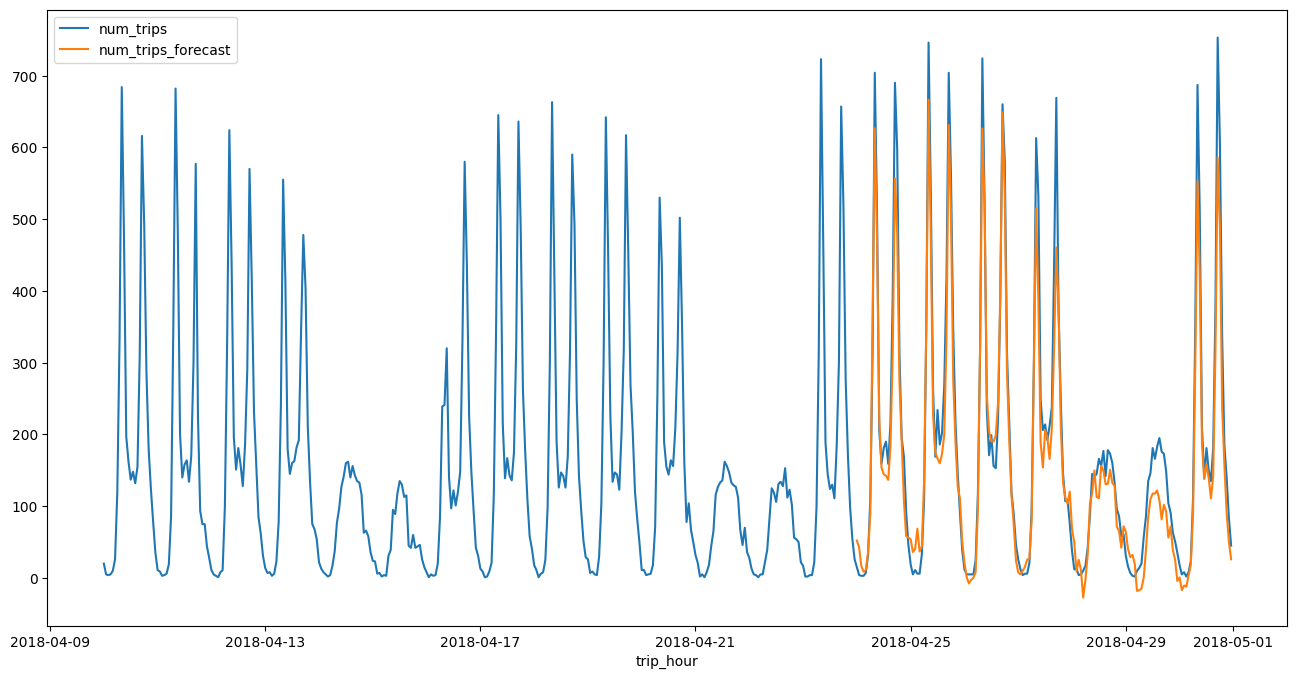

In [10]:
df_all = df_all.set_index("trip_hour")
df_all.plot.line(figsize=(16, 8))